## Dataset creation

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Creation of Pandas DataFrame
df_case = pd.read_csv("Korea/PatientInfo.csv")
df_case = df_case.rename(columns = {'confirmed_date':'date'})
df_float = pd.read_csv("Korea/SeoulFloating.csv")
df_regions = pd.read_csv("Korea/Region.csv")
df_weather = pd.read_csv("Korea/Weather.csv")

In [4]:
# Create a DataFrame time_series with number of cases per city, group age, sex and date
infected = df_case.groupby(['date', 'city', 'age', 'sex']).count().reset_index()
time_series = infected[['date', 'city', 'age', 'sex', 'patient_id']].copy()
time_series['age'] = time_series['age'].apply(lambda x : int(x[:-1]))
time_series.sort_values(by=['city', 'age', 'sex', 'date'], inplace = True)
time_series = time_series.reset_index(drop = True)

In [5]:
# This function generate a better suited time series used for forecasting new hospitalisation cases
def construct_time_series(df):
    overall_shift = 0
    while np.isnan([df.shift(-overall_shift).loc[0]['patient_id']]) == False:
        list_time = [df.shift(-overall_shift).loc[0]['patient_id']]
        old_shift = overall_shift
        new_shift = overall_shift+1
        while (new_shift != 0) :
            if (df.shift(-old_shift).loc[0]['city'] == df.shift(-new_shift).loc[0]['city'] and df.shift(-old_shift).loc[0]['age'] == df.shift(-new_shift).loc[0]['age'] and df.shift(-old_shift).loc[0]['sex'] == df.shift(-new_shift).loc[0]['sex']):
                interval = (datetime.strptime(df.shift(-new_shift).loc[0]['date'], '%Y-%m-%d') - datetime.strptime(df.shift(-old_shift).loc[0]['date'], '%Y-%m-%d')).days
                list_time.extend([0]*(interval-1))
                list_time.append(df.shift(-new_shift).loc[0]['patient_id'])
                new_shift += 1
                old_shift +=1
                overall_shift += 1
            else :
                new_shift = 0
                overall_shift += 1
        yield list_time, df.shift(-overall_shift+1).loc[0]['date'], overall_shift-1

In [6]:
# Create the time series
from statsmodels.tsa.ar_model import AR
time_generator = construct_time_series(time_series)
time_series['list_cases'] = np.empty((len(time_series), 0)).tolist()

In [7]:
# Forecast the new hospitalisation cases up to 25 April 2020
for cases in time_generator:
    try :
        interval = (datetime.strptime('2020-04-25', '%Y-%m-%d') - datetime.strptime(cases[1], '%Y-%m-%d')).days
        model = AR(cases[0])
        model_fit = model.fit()
        yhat = model_fit.predict(len(cases[0]), interval)
        cases[0].extend(yhat)
        time_series.at[cases[2], 'list_cases'] = cases[0]
    except ValueError : 
        cases[0].extend([0]*interval)
        time_series.at[cases[2], 'list_cases'] = cases[0]

/Users/lucaseckes/miniconda2/envs/hack/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_

In [8]:
# Create the new DataFrame taking into account the forecasted cases
time_series = time_series[time_series.astype(str)['list_cases'] != '[]'].explode('list_cases') \
.drop(['patient_id'], axis = 1).reset_index(drop = True)

In [9]:
# Create the corresponding dates of the time series
def change_dates(df):
    for i in range(len(df)-1):
        if df.loc[i]['city'] == df.loc[i+1]['city'] and df.loc[i]['age'] == df.loc[i+1]['age'] and df.loc[i]['sex'] == df.loc[i+1]['sex'] :
            df.at[i+1, 'date'] = (datetime.strptime(df.loc[i]['date'], '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    return df

In [10]:
# Create the new DataFrame values using the time series forecasting
df_case = change_dates(time_series)
case_city = pd.DataFrame(df_case.groupby(['date', 'city']).count()['list_cases']).reset_index()
fp_city = pd.DataFrame(df_float.groupby(['date', 'city']).sum()['fp_num']).reset_index()
fp_age = pd.DataFrame(df_float.groupby(['date', 'city', 'sex', 'birth_year']).sum()['fp_num']).reset_index()

In [11]:
# Include the floating population data
# Note that some cases data will be removed because there is no floating data in the region of contamination
df_corona = case_city.merge(fp_city, how='right', on = ['date', 'city']).fillna(0)
df_corona = df_corona.drop(['list_cases'], axis = 1).sort_values(['date'])

In [12]:
# We assume that the contraction of the disease occur between 2 and 12 days before the hospitalisation time
def symptom_apparition(date, onset):
    if onset == True:
        contamination = [(datetime.strptime(date, '%Y-%m-%d') - timedelta(days=x)).strftime('%Y-%m-%d') for x in range(2,12)]
    else : 
        contamination = [(datetime.strptime(date, '%Y-%m-%d') - timedelta(days=x)).strftime('%Y-%m-%d') for x in range(2,12)]
    return contamination

In [13]:
# The dates will now coorespond to the apparition of the disease and not the hospitalisation time
df_case['contamination_period'] = df_case['date'].apply(lambda x : symptom_apparition(x, False)  if pd.notnull(x) else 'NaN')
case_daily = df_case[['contamination_period', 'city', 'sex', 'age', 'list_cases']].explode('contamination_period').groupby(['contamination_period', 'city', 'sex', 'age']).count().reset_index()

In [14]:
# Give the daily symptoms cases for city, age group, sex
df_corona = df_corona.merge(case_daily, left_on = ['date', 'city'], right_on = ['contamination_period', 'city']) \
.drop(['contamination_period'], axis = 1)
df_corona = df_corona.rename(columns = {'list_cases':'total_number'})
df_corona['contaminated'] = np.ones(len(df_corona))

In [15]:
# Merge the others datasets with all the other valuable informations
df_corona = df_corona.merge(fp_age, how = 'right', left_on = ['date', 'city', 'sex', 'age'], right_on = ['date', 'city', 'sex', 'birth_year']) \
.drop(['age'], axis = 1)
df_corona['combined'] = df_corona[['total_number', 'fp_num_y']].values.tolist()
df_corona = df_corona.explode('combined').drop(['total_number', 'fp_num_y'], axis = 1)
df_corona = df_corona.merge(fp_city, how='right', on = ['date', 'city']).fillna(0).drop(['fp_num_x'], axis = 1)
df_corona['contaminated'] = df_corona.apply(lambda x : 1-x.index%2)['contaminated']
df_corona['new_combined'] = df_corona['combined'].diff()
df_corona['group_number'] = np.where(df_corona.index % 2 == 0, df_corona.combined, df_corona.new_combined)
df_corona = df_corona.drop(['combined', 'new_combined'], axis = 1)
df_corona = df_corona.rename(columns = {'fp_num':'total_number'})
df_corona = df_corona.merge(df_regions, on = ['city']).drop(['code'], axis = 1)
df_corona = df_corona.merge(df_weather, on = ['date', 'province'])

In [19]:
# Calculate the proportion of case in the floating population
infected = df_corona.groupby(['contaminated', 'date', 'city']).sum().reset_index()
nb_infected = infected[infected['contaminated'] == 1][['group_number', 'date', 'city']]
df_corona = df_corona.merge(nb_infected, on = ['date', 'city'])
df_corona['proportion_case'] = df_corona['group_number_y']/df_corona['total_number']
df_corona = df_corona.drop(['group_number_y'], axis = 1)
df_corona.sort_values(by=['date', 'city', 'birth_year', 'sex', 'contaminated'], inplace = True)
df_corona['precipitation'].fillna(0, inplace = True)

In [21]:
# Final DataFrame
df_corona = df_corona.rename(columns = {'birth_year':'age', 'group_number_x':'group_number'})
df_corona[['date', 'city', 'province', 'latitude', 'longitude', 'sex',
       'age', 'contaminated', 'group_number', 'total_number', 'proportion_case',
       'elementary_school_count', 'kindergarten_count', 'university_count',
       'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio',
       'nursing_home_count', 'code', 'avg_temp', 'min_temp', 'max_temp',
       'precipitation', 'max_wind_speed', 'most_wind_direction',
       'avg_relative_humidity']]
df_corona.to_csv('corona.csv')

## Graphs

### Contamination across population

In [51]:
# Bar chart contamination across population vs categorical data
def contamination_graphs_cat(df_contaminated, column):
    bins = df_corona[column].unique()
    heights = []
    for x in bins:
        heights.append(np.mean(df_contaminated['proportion_case'][df_contaminated[column]==x]))
    return bins, heights

In [31]:
# Histogram contamination across population vs continuous data
def contamination_graphs_cont(df_contaminated, column):
    x = list(df_contaminated[column])
    counts, bins = np.histogram(x)
    weights = []
    for i in range(len(bins)-1) : 
        weights.append(np.mean(df_contaminated['proportion_case'][(df_contaminated[column] > bins[i]) & (df_contaminated[column] < bins[i+1])]))
    return x, bins[:-1], weights

In [27]:
df_contaminated = df_corona[df_corona['contaminated'] == 1].copy()
df_contaminated.columns

Index(['date', 'city', 'sex', 'contaminated', 'age', 'total_number',
       'group_number', 'province', 'latitude', 'longitude',
       'elementary_school_count', 'kindergarten_count', 'university_count',
       'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio',
       'nursing_home_count', 'code', 'avg_temp', 'min_temp', 'max_temp',
       'precipitation', 'max_wind_speed', 'most_wind_direction',
       'avg_relative_humidity', 'proportion_case'],
      dtype='object')

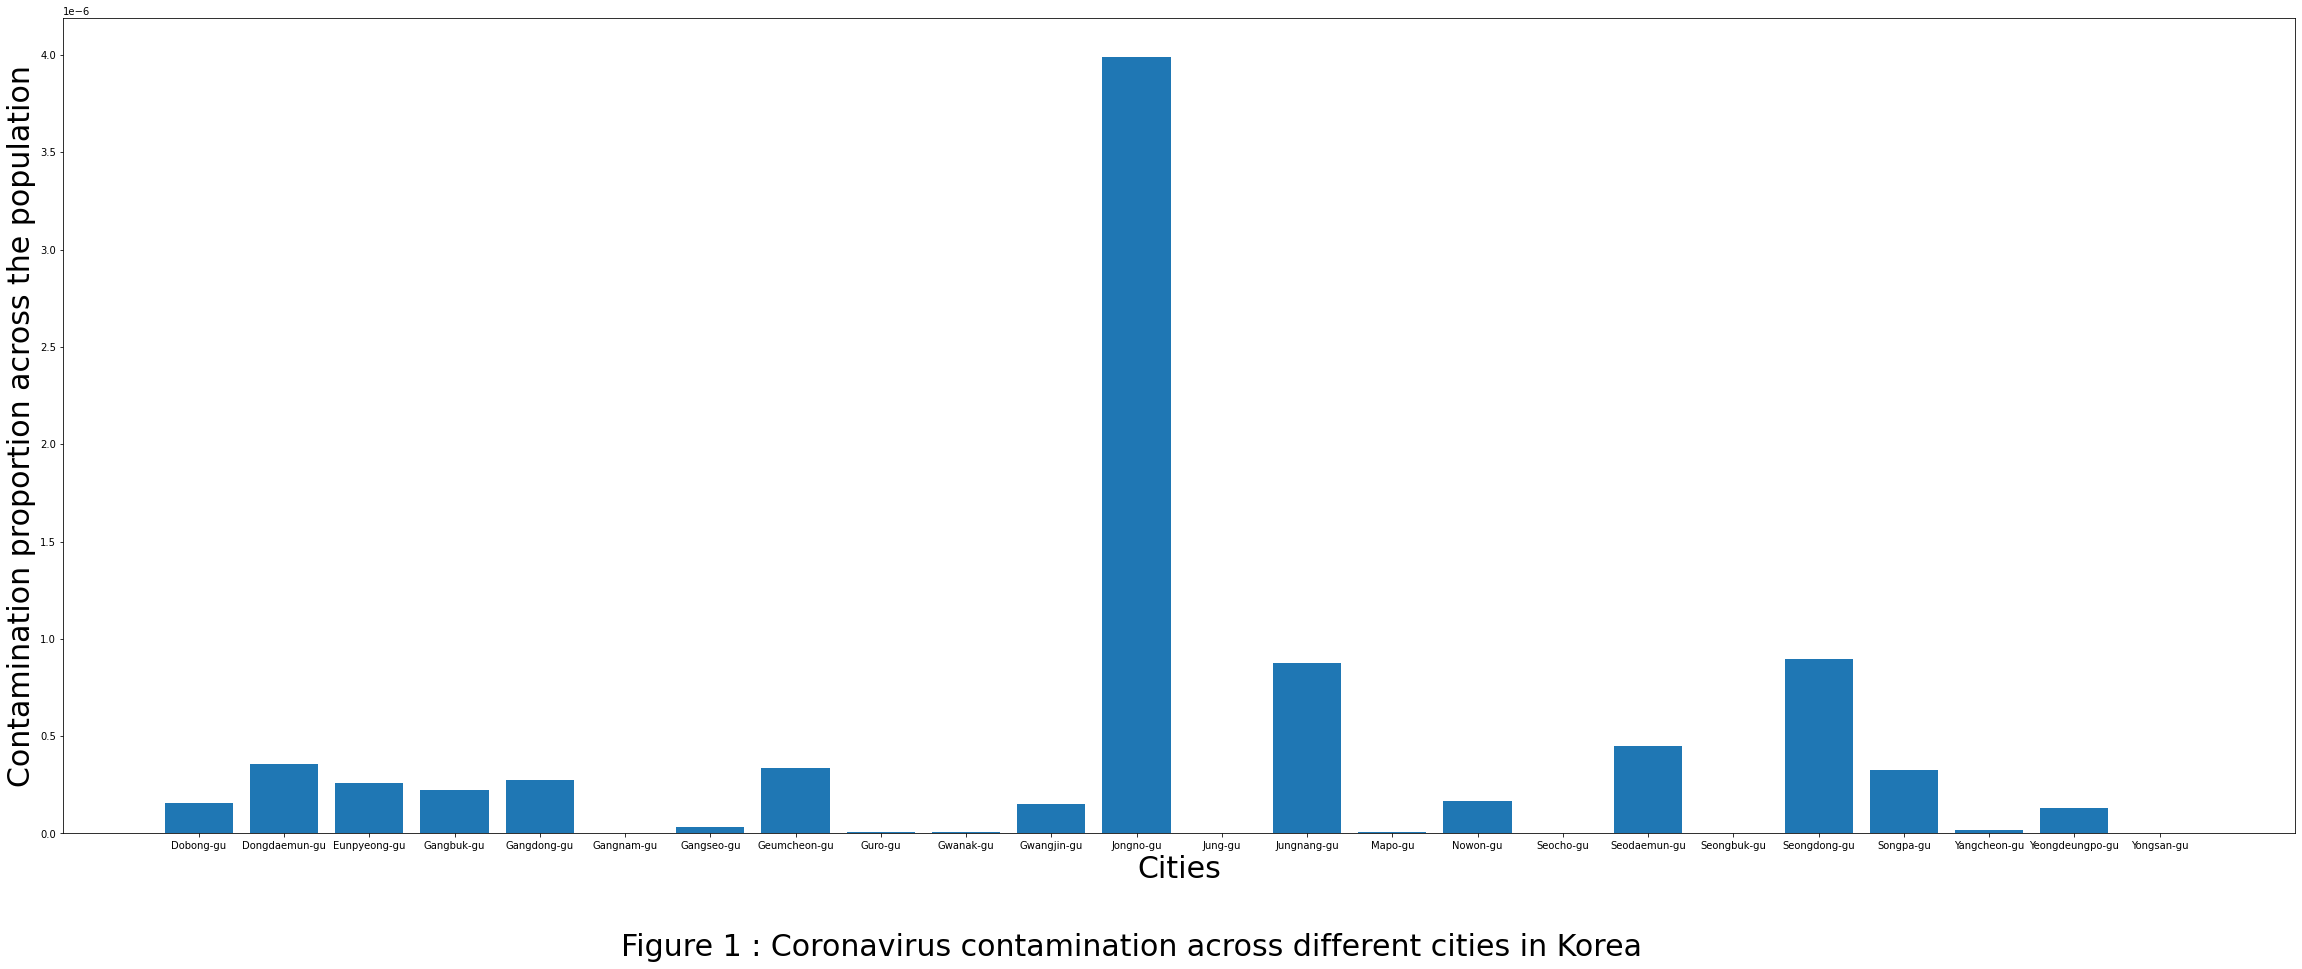

In [30]:
bins, heights = contamination_graphs_cat(df_contaminated, 'city')
plt.figure(figsize=(40,15))
plt.bar(bins, heights)
plt.xlabel('Cities', fontsize = 30)
plt.ylabel('Contamination proportion across the population', fontsize = 30)
ax = plt.gca()
plt.text(0.25, -0.15, "Figure 1 : Coronavirus contamination across different cities in Korea", fontsize=30, transform=ax.transAxes)
plt.savefig('cities.png', bbox_inches="tight")

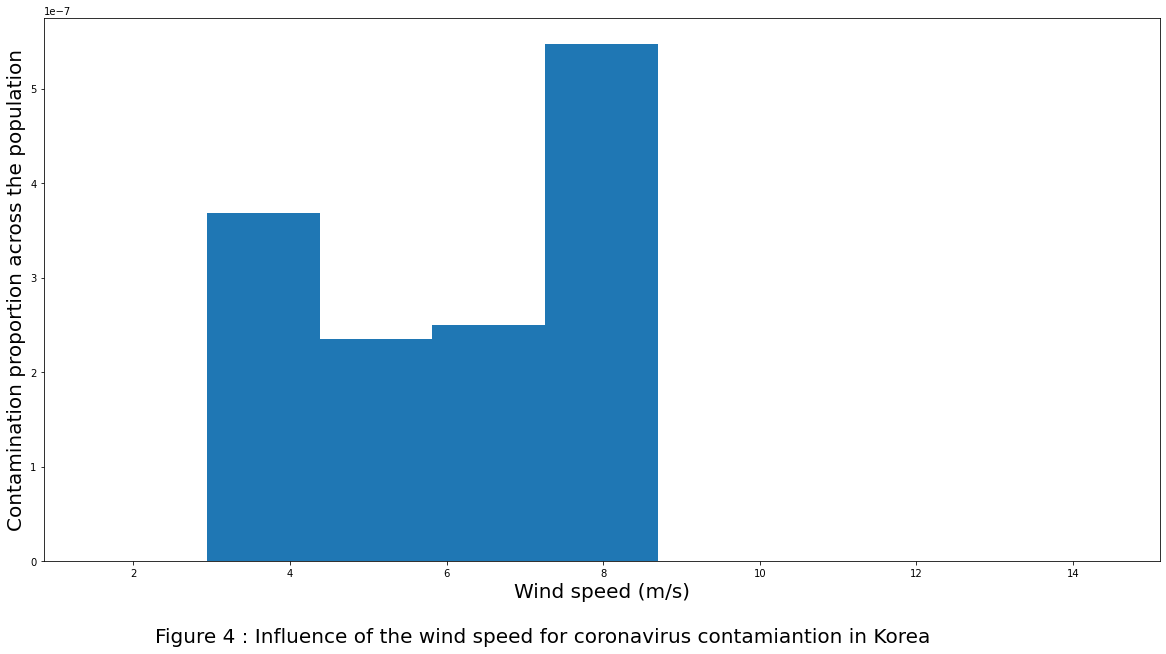

In [33]:
x, bins, weights = contamination_graphs_cont(df_contaminated, 'max_wind_speed')
plt.figure(figsize=(20,10))
plt.hist(bins, range = (np.min(x), np.max(x)), weights = weights)
plt.xlabel('Wind speed (m/s)', fontsize = 20)
plt.ylabel('Contamination proportion across the population', fontsize = 20)
ax = plt.gca()
plt.text(0.1, -0.15, "Figure 4 : Influence of the wind speed for coronavirus contamiantion in Korea", fontsize=20, transform=ax.transAxes)
plt.savefig('wind_speed.png')

### Comparaison between two cities and age groups

In [42]:
df_nocontaminated = df_corona[df_corona['contaminated'] == 0].copy()
df_gwa = df_nocontaminated[df_nocontaminated['city']=='Gwanak-gu']
df_dob = df_nocontaminated[df_nocontaminated['city']=='Dobong-gu']

In [52]:
heights1 = []
heights2 = []
heights3 = []
heights4 = []
for x in bins:
    heights1.append(np.mean(df_gwa['group_number'][(df_gwa['age'] == x) & (df_gwa['sex']=='male')]/df_gwa['total_number']))
    heights2.append(np.mean(df_gwa['group_number'][(df_gwa['age'] == x) & (df_gwa['sex']=='female')]/df_gwa['total_number']))
    heights3.append(np.mean(df_dob['group_number'][(df_dob['age'] == x) & (df_dob['sex']=='male')]/df_dob['total_number']))
    heights4.append(np.mean(df_dob['group_number'][(df_dob['age'] == x) & (df_dob['sex']=='female')]/df_dob['total_number']))

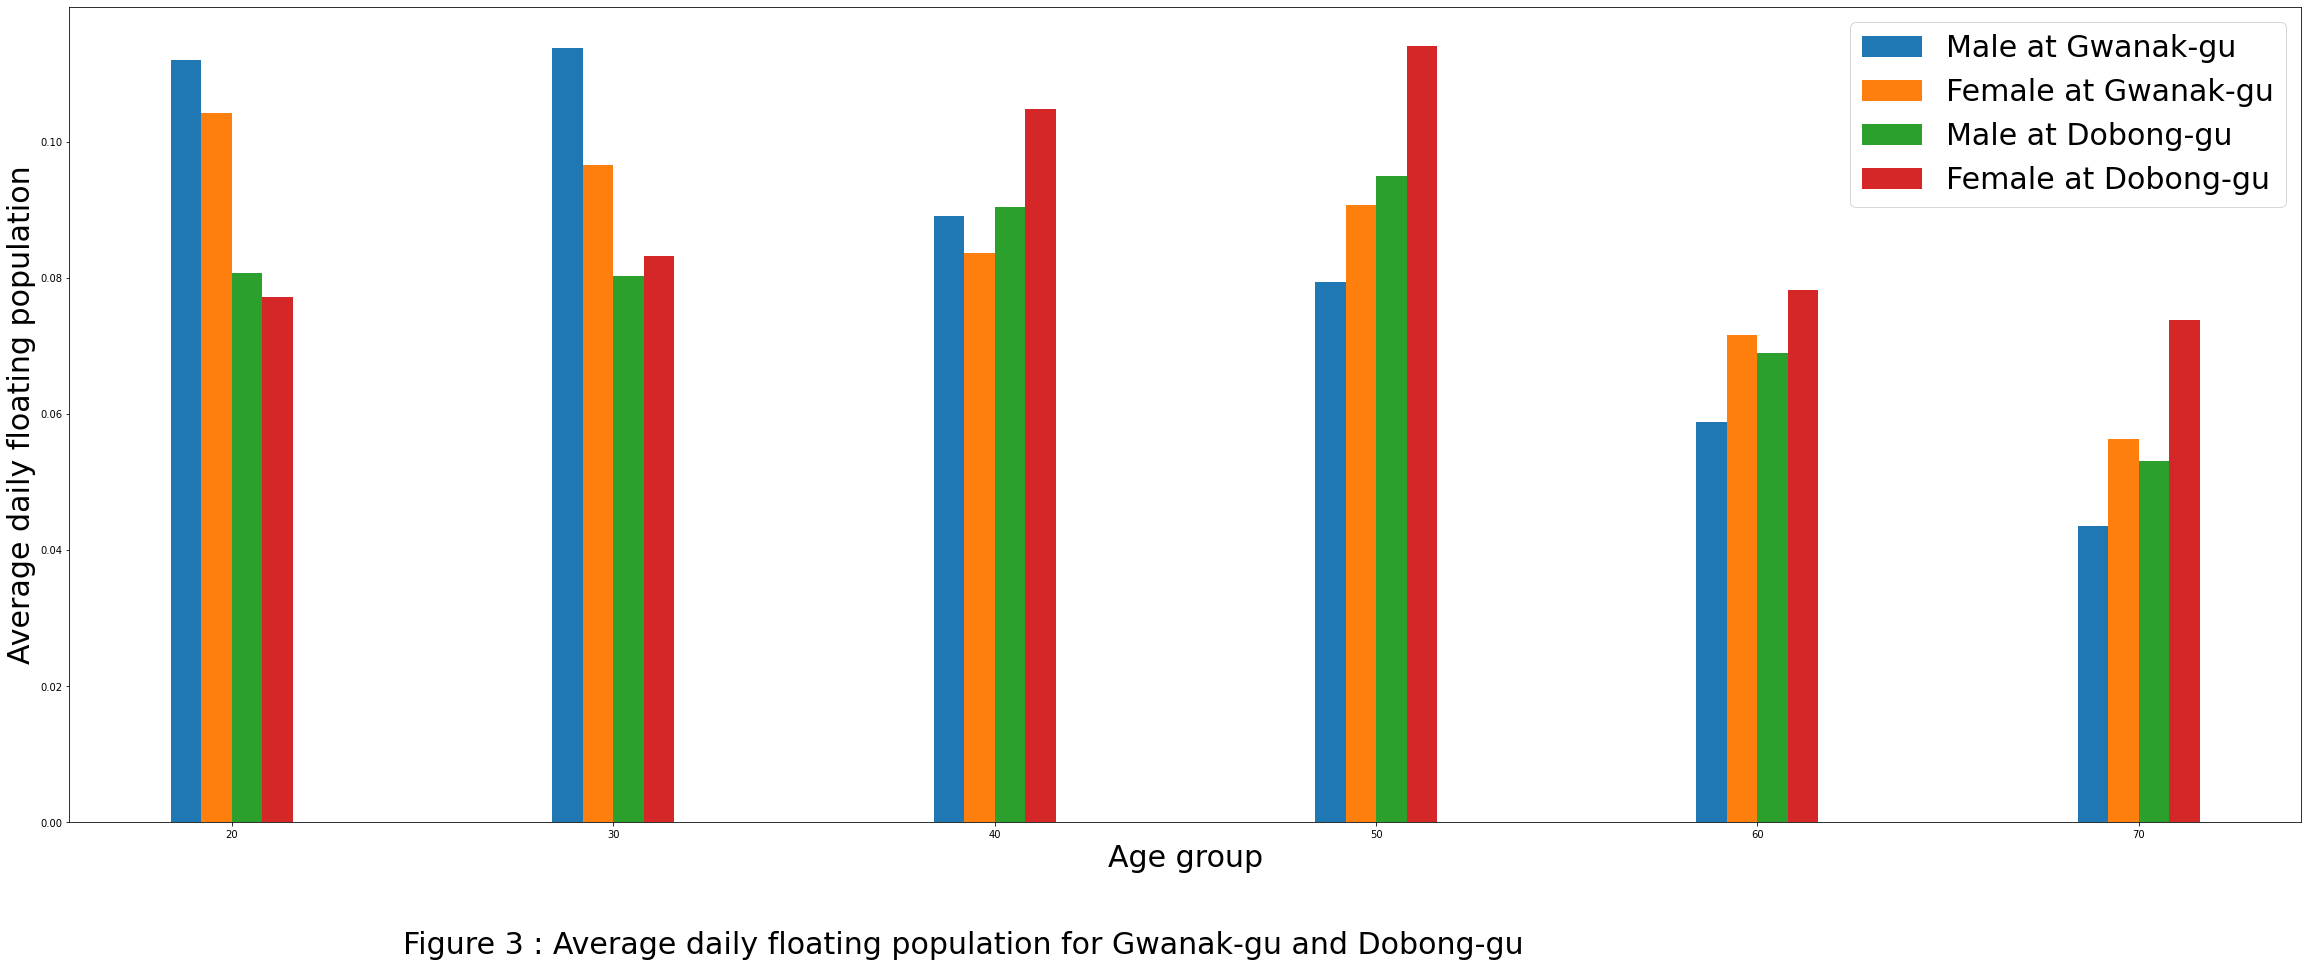

In [53]:
plt.figure(figsize=(40,15))
plt.bar(bins-1.2, heights1)
plt.bar(bins-0.4, heights2)
plt.bar(bins+0.4, heights3)
plt.bar(bins+1.2, heights4)
plt.xlabel('Age group', fontsize = 30)
plt.ylabel('Average daily floating population', fontsize = 30)
plt.legend(['Male at Gwanak-gu', 'Female at Gwanak-gu', 'Male at Dobong-gu', 'Female at Dobong-gu'], prop={'size': 30})
plt.text(0.2, -0.15, "Figure 3 : Average daily floating population for Gwanak-gu and Dobong-gu", fontsize=30, transform=ax.transAxes)
plt.savefig('age_city.png')